#### Sales Forecast Predictor

##### Goal: To analyze the dataset, preprocess the data, perform feature engineering, prepare the data for training, make predictions, evaluate the model and visualize the results.

In [3]:
# Imports

import pandas as pd   
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



In [ ]:
# Load the dataset

data = pd.read_csv("train.csv")
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


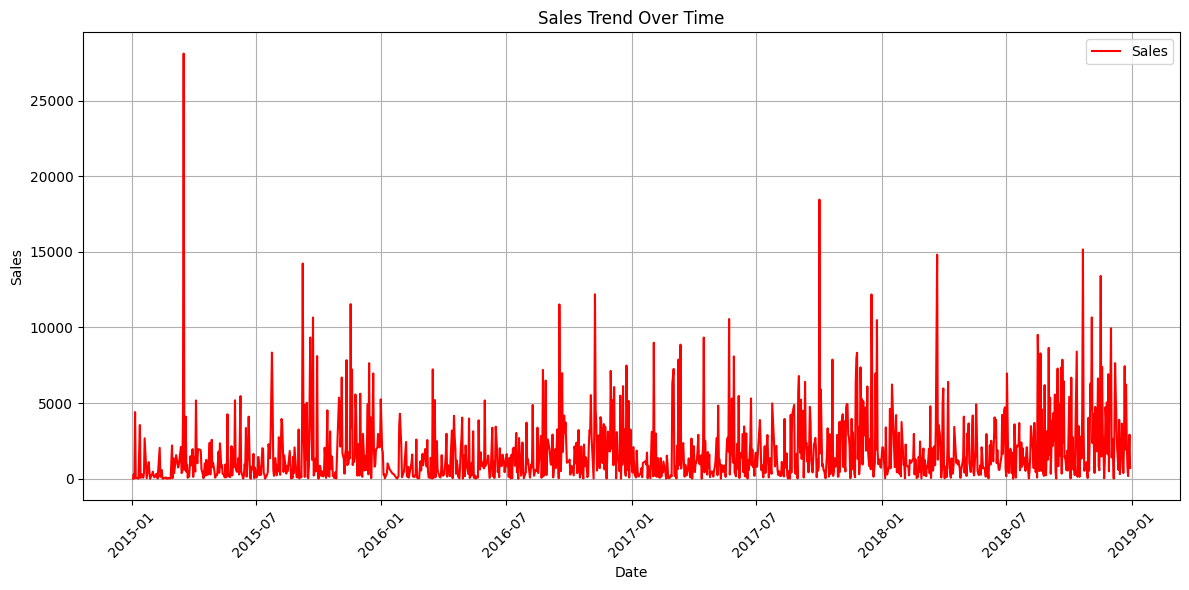

In [38]:
# Data Preprocessing

# To perform time based operations convert the 'Order Date' column into datatime format.
data['Order Date'] = pd.to_datetime(data['Order Date'], format = '%d/%m/%Y')

# Group by 'Order Date' and sum the sales for each date to create a time series of daily sales
sales_by_date = data.groupby('Order Date')['Sales'].sum().reset_index()


# Sales trend over time visualization

plt.figure(figsize = (12,6))
plt.plot(sales_by_date['Order Date'], sales_by_date['Sales'],
         label = 'Sales' , color = 'red')
plt.title("Sales Trend Over Time")
plt.xlabel ('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()



In [65]:
# Feature Engineering

def create_lagged_features(data, lag = 1):
    lagged_data = data.copy()
    for i in range(1, lag+1):
        lagged_data[f'lag_{i}'] = lagged_data['Sales'].shift(i)
    return lagged_data

lag = 30
sales_with_lags = create_lagged_features(data[['Order Date', 'Sales']], lag)

sales_with_lags = sales_with_lags.dropna()    

In [66]:
# Data preparation for training

X = sales_with_lags.drop(columns = ['Order Date', 'Sales'])
y = sales_with_lags['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False) 


In [67]:
# Training the XGBoost Model

model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 100, learning_rate = 0.1, max_depth = 5)
model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [68]:
import numpy as np
# Making Predictions and Evaluating the Model

predictions_xgb = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, predictions_xgb))

# Print results
print(f'RMSE: {rmse_xgb:.2f}')

RMSE: 686.46


##### RMSE indicates the average deviation between the actual and predicted values. The lower the better, meaning we can increase the number of lags in this specific case to improve the model's accuracy

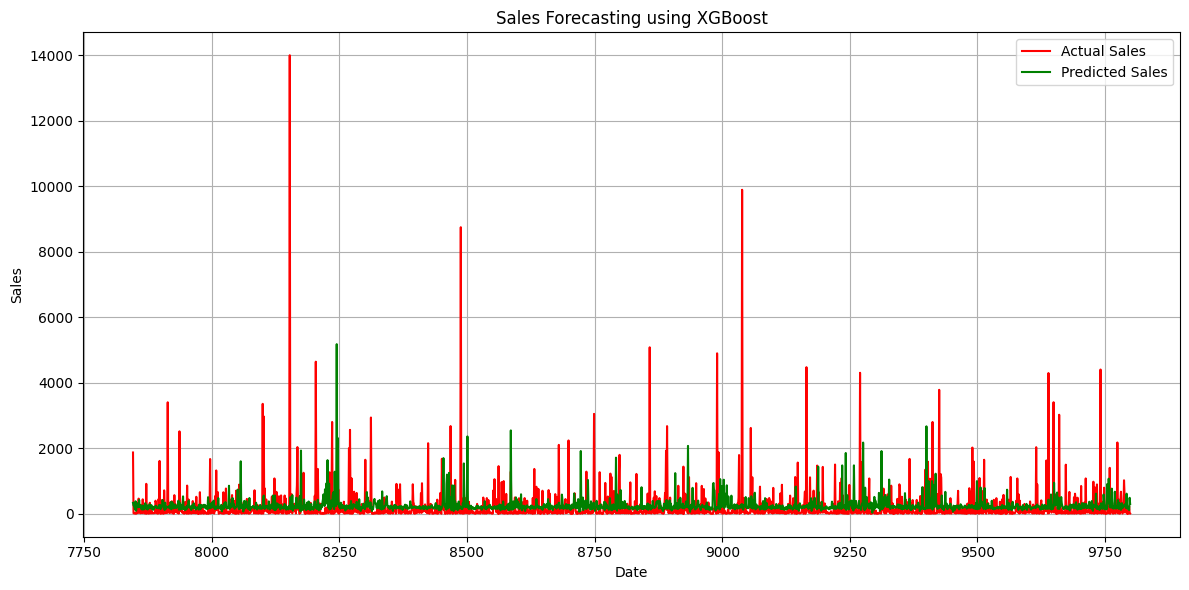

In [69]:
# Results visualization

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Sales', color='red')
plt.plot(y_test.index, predictions_xgb, label='Predicted Sales', color='green')
plt.title('Sales Forecasting using XGBoost')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()